#FINRL Train Stock Trading
https://github.com/AI4Finance-LLC/FinRL/blob/master/finrl/train.py

In this work SAC used as RL agorithm rather than D Q-Network. The reason of this choice explained in "Train Model" section.

Multi-stock trading data used in train and trade data part. So this work related to multi-stock trading with RL. DOW The latest market data for all 30 stocks in the Dow Jones Industrial Average. So in this work there is "BIST_30_TICKER" relates with that.



#SETUP

In [1]:
 # Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-a3tr2akm
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-a3tr2akm
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-8ii8evo_/pyfolio_3cd781d1d63441d1a4e70b06ca7067a8
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-8ii8evo_/pyfolio_3cd781d1d63441d1a4e70b06ca7067a8


In [2]:
#for data download part -- yahoo finance
!pip install yfinance

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

matplotlib.use("Agg")
import datetime

from finrl.apps import config
# from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
# from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import itertools


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import pandas as pd
import yfinance as yf

#Collect Data

In [5]:
stockList = ["AKBNK.IS","ARCLK.IS","ASELS.IS","BIMAS.IS","DOHOL.IS","EKGYO.IS","EREGL.IS","FROTO.IS","GARAN.IS","GUBRF.IS","HALKB.IS","ISCTR.IS","KCHOL.IS","KOZAA.IS","KOZAL.IS",
"KRDMD.IS","PETKM.IS","PGSUS.IS","SAHOL.IS","SASA.IS","SISE.IS","TAVHL.IS","TCELL.IS","THYAO.IS","TKFEN.IS","TTKOM.IS","TUPRS.IS","VAKBN.IS","VESTL.IS","YKBNK.IS"]
len(stockList)

30

In [6]:
tickers = ["VESTL.IS","VAKBN.IS","TUPRS.IS","THYAO.IS","HALKB.IS","SASA.IS","PETKM.IS","SAHOL.IS","PGSUS.IS","GARAN.IS","AKBNK.IS","ARCLK.IS","BIMAS.IS","EREGL.IS"] # 14 tane hisse


In [7]:
date1="2015-07-27"
date2="2021-07-28"
list_data = []
for ticker in tickers:
  data = yf.download(tickers=ticker , start=date1, end=date2, interval='1d' )
  data["tic"] = ticker
  data["date"] = data.index
  data = data.reset_index()
  list_data.append(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
import pandas as pd
df = pd.concat(list_data)

del df['Date']

In [9]:

df.isna().sum()
multi_ticker_df = df.ffill().bfill()
print(multi_ticker_df)

           Open       High        Low  ...    Volume       tic       date
0      4.450000   4.450000   4.330000  ...   1074220  VESTL.IS 2015-07-27
1      4.450000   4.470000   4.370000  ...   1609540  VESTL.IS 2015-07-28
2      4.430000   4.460000   4.410000  ...    981396  VESTL.IS 2015-07-29
3      4.480000   4.490000   4.430000  ...    871776  VESTL.IS 2015-07-30
4      4.480000   4.650000   4.480000  ...   6003500  VESTL.IS 2015-07-31
...         ...        ...        ...  ...       ...       ...        ...
1526  17.990000  18.400000  17.990000  ...  19197906  EREGL.IS 2021-07-14
1527  18.250000  18.250000  17.910000  ...  17163796  EREGL.IS 2021-07-16
1528  18.000000  18.030001  17.850000  ...   5709839  EREGL.IS 2021-07-19
1529  18.040001  18.250000  18.000000  ...  23665915  EREGL.IS 2021-07-26
1530  18.070000  18.490000  17.969999  ...  25081610  EREGL.IS 2021-07-27

[21434 rows x 8 columns]


In [10]:
multi_ticker_df.columns= multi_ticker_df.columns.str.strip().str.lower()
multi_ticker_df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'tic', 'date'], dtype='object')

In [11]:
def prefill(multi_ticker_df)  :
    df = multi_ticker_df.copy()
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]
    merged_closes = df.pivot_table(index = 'date',columns = 'tic', values = 'close')

    print(merged_closes.isna().sum())
    merged_closes = merged_closes.ffill().bfill()

    # print(merged_closes.isna().sum())
    # print(merged_closes)
    tics = merged_closes.columns
    df = df[df.tic.isin(tics)]
    df = df.reset_index()
    del df['index']
    return df
multiticker_df = prefill(multi_ticker_df)


tic
AKBNK.IS    0
ARCLK.IS    0
BIMAS.IS    0
EREGL.IS    0
GARAN.IS    0
HALKB.IS    0
PETKM.IS    0
PGSUS.IS    0
SAHOL.IS    0
SASA.IS     0
THYAO.IS    0
TUPRS.IS    0
VAKBN.IS    0
VESTL.IS    0
dtype: int64


In [12]:
print(multiticker_df)

            open       high        low  ...    volume       tic       date
0       6.182181   6.182181   6.122160  ...  13466375  AKBNK.IS 2015-07-27
1      14.750000  14.950000  14.500000  ...   1976842  ARCLK.IS 2015-07-27
2      23.525000  23.799999  23.325001  ...    628882  BIMAS.IS 2015-07-27
3       3.990000   4.040000   3.960000  ...   6776403  EREGL.IS 2015-07-27
4       7.900000   7.910000   7.740000  ...  63095366  GARAN.IS 2015-07-27
...          ...        ...        ...  ...       ...       ...        ...
21429  29.680000  30.299999  29.340000  ...  15605997   SASA.IS 2021-07-27
21430  12.310000  12.600000  12.240000  ...  90420698  THYAO.IS 2021-07-27
21431  91.849998  92.500000  91.000000  ...   2781736  TUPRS.IS 2021-07-27
21432   3.430000   3.440000   3.390000  ...  30871452  VAKBN.IS 2021-07-27
21433  31.980000  32.099998  31.740000  ...   1726049  VESTL.IS 2021-07-27

[21434 rows x 8 columns]


#Feature Engineering

In [13]:
print("==============Start Feature Engineering===========")
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=tech_indicator_list,
    use_turbulence=True,
    user_defined_feature=False,
)

==============Start Feature Engineering===========


In [14]:
tech_indicator_list

['macd', 'rsi_30', 'cci_30', 'dx_30']

In [15]:
processed = fe.preprocess_data(multiticker_df)


Successfully added technical indicators
Successfully added turbulence index


In [16]:
processed

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
1,14.750000,14.950000,14.500000,14.600000,11.878804,1976842,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
2,23.525000,23.799999,23.325001,23.600000,19.072001,628882,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
3,3.990000,4.040000,3.960000,4.040000,1.965522,6776403,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
4,7.900000,7.910000,7.740000,7.760000,6.942376,63095366,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21429,29.680000,30.299999,29.340000,29.540001,29.540001,15605997,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,8.604229
21430,12.310000,12.600000,12.240000,12.550000,12.550000,90420698,THYAO.IS,2021-07-27,-0.338376,42.154444,-164.845461,45.507105,8.604229
21431,91.849998,92.500000,91.000000,92.349998,92.349998,2781736,TUPRS.IS,2021-07-27,-1.613261,42.913015,-125.319653,47.509144,8.604229
21432,3.430000,3.440000,3.390000,3.420000,3.420000,30871452,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,8.604229


In [17]:
processed_full = processed.sort_values(['date','tic'])
processed_full= processed_full.ffill().bfill()
print(processed_full)

            open       high        low  ...      cci_30       dx_30  turbulence
0       6.182181   6.182181   6.122160  ...   66.666667  100.000000    0.000000
1      14.750000  14.950000  14.500000  ...   66.666667  100.000000    0.000000
2      23.525000  23.799999  23.325001  ...   66.666667  100.000000    0.000000
3       3.990000   4.040000   3.960000  ...   66.666667  100.000000    0.000000
4       7.900000   7.910000   7.740000  ...   66.666667  100.000000    0.000000
...          ...        ...        ...  ...         ...         ...         ...
21429  29.680000  30.299999  29.340000  ...  -26.532921   13.879146    8.604229
21430  12.310000  12.600000  12.240000  ... -164.845461   45.507105    8.604229
21431  91.849998  92.500000  91.000000  ... -125.319653   47.509144    8.604229
21432   3.430000   3.440000   3.390000  ... -143.798826   35.035782    8.604229
21433  31.980000  32.099998  31.740000  ...   90.842671   11.440791    8.604229

[21434 rows x 13 columns]


# Training & Trading data split

In [18]:
date1="2015-07-27"
date2="2021-07-28"
date3= "2020-07-27"

In [19]:
train = data_split(processed_full,date1, date3)
trade = data_split(processed_full, date3, date2)


# Calculate state action space


In [20]:
stock_dimension = len(train.tic.unique()) # number of tickers
state_space = (
        1
        + 2 * stock_dimension
        + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension)

In [21]:
stock_dimension ,state_space

(14, 85)

# ENV CREATE

##Define ENV

In [22]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
#from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df, 
                stock_dim,
                hmax,                
                initial_amount,
                buy_cost_pct,
                sell_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                risk_indicator_col='turbulence',
                make_plots = False, 
                print_verbosity = 10,
                day = 0, 
                initial=True,
                previous_state=[],
                model_name = '',
                mode='',
                iteration=''):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space,))
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name=model_name
        self.mode=mode 
        self.iteration=iteration
        # initalize state
        self.state = self._initiate_state()
        
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self._get_date()]
        #self.reset()
        self._seed()
        


    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index+1]>0: 
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index+self.stock_dim+1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(abs(action),self.state[index+self.stock_dim+1])
                    sell_amount = self.state[index+1] * sell_num_shares * (1- self.sell_cost_pct)
                    #update balance
                    self.state[0] += sell_amount

                    self.state[index+self.stock_dim+1] -= sell_num_shares
                    self.cost +=self.state[index+1] * sell_num_shares * self.sell_cost_pct
                    self.trades+=1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares
            
        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence>=self.turbulence_threshold:
                if self.state[index+1]>0: 
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions 
                    if self.state[index+self.stock_dim+1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index+self.stock_dim+1]
                        sell_amount = self.state[index+1]*sell_num_shares* (1- self.sell_cost_pct)
                        #update balance
                        self.state[0] += sell_amount
                        self.state[index+self.stock_dim+1] =0
                        self.cost += self.state[index+1]*sell_num_shares* \
                                    self.sell_cost_pct
                        self.trades+=1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    
    def _buy_stock(self, index, action):

        def _do_buy():
            if self.state[index+1]>0: 
                #Buy only if the price is > 0 (no missing data in this particular date)       
                available_amount = self.state[0] // self.state[index+1]
                # print('available_amount:{}'.format(available_amount))
                
                #update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = self.state[index+1] * buy_num_shares * (1+ self.buy_cost_pct)
                self.state[0] -= buy_amount

                self.state[index+self.stock_dim+1] += buy_num_shares
                
                self.cost+=self.state[index+1] * buy_num_shares * self.buy_cost_pct
                self.trades+=1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence< self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory,'r')
        plt.savefig('results/account_value_trade_{}.png'.format(self.episode))
        plt.close()

    def step(self, actions):
        print("STEPPPP")
        self.terminal = self.day >= len(self.df.index.unique())-1
        print(self.terminal)
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()            
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount 
            df_total_value.columns = ['account_value']
            df_total_value['date'] = self.date_memory
            df_total_value['daily_return']=df_total_value['account_value'].pct_change(1)
            if df_total_value['daily_return'].std() !=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ['account_rewards']
            df_rewards['date'] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value['daily_return'].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name!='') and (self.mode!=''):
                df_actions = self.save_action_memory()
                df_actions.to_csv('results/actions_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration))
                df_total_value.to_csv('results/account_value_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration),index=False)
                df_rewards.to_csv('results/account_rewards_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration),index=False)
                plt.plot(self.asset_memory,'r')
                plt.savefig('results/account_value_{}_{}_{}.png'.format(self.mode,self.model_name, self.iteration),index=False)
                plt.close()

            # Add outputs to logger interface
            #logger.record("environment/portfolio_value", end_total_asset)
            #logger.record("environment/total_reward", tot_reward)
            #logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            #logger.record("environment/total_cost", self.cost)
            #logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax #actions initially is scaled between 0 to 1
            actions = (actions.astype(int)) #convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence>=self.turbulence_threshold:
                    actions=np.array([-self.hmax]*self.stock_dim)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]
            
            
            
            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)
            #state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day,:]    
            if self.turbulence_threshold is not None:     
                self.turbulence = self.data[self.risk_indicator_col].values[0]
            print(self.state)
            self.state =  self._update_state()
            print(self.state)

            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset            
            self.rewards_memory.append(self.reward)
            self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        #initiate state
        self.state = self._initiate_state()
        
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self._get_date()]
        
        self.episode+=1

        return self.state
    
    def render(self, mode='human',close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique())>1:
                # for multiple stock
                state = [self.initial_amount] + \
                         self.data.close.values.tolist() + \
                         [0]*self.stock_dim  + \
                         sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
                print("initial_state", state)
            else:
                # for single stock
                state = [self.initial_amount] + \
                        [self.data.close] + \
                        [0]*self.stock_dim  + \
                        sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        else:
            #Using Previous State
            if len(self.df.tic.unique())>1:
                # for multiple stock
                state = [self.previous_state[0]] + \
                         self.data.close.values.tolist() + \
                         self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]  + \
                         sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
            else:
                # for single stock
                state = [self.previous_state[0]] + \
                        [self.data.close] + \
                        self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]  + \
                        sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        return state

    def _update_state(self):
        if len(self.df.tic.unique())>1:
            # for multiple stock
            
            state =  [self.state[0]] + \
                      self.data.close.values.tolist() + \
                      list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
        else:
            # for single stock
            state =  [self.state[0]] + \
                     [self.data.close] + \
                     list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                     sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
                          
        return state

    def _get_date(self):
        if len(self.df.tic.unique())>1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique())>1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ['date']
            
            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [23]:
env_kwargs = {
        "hmax": 100, 
        "initial_amount": 1000000, 
        "buy_cost_pct": 0.001, 
        "sell_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4}

In [24]:
e_train_gym = StockTradingEnv(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

initial_state [1000000, 6.165031909942627, 14.600000381469727, 23.600000381469727, 4.039999961853027, 7.760000228881836, 11.399999618530273, 1.5427709817886353, 23.5, 9.279999732971191, 0.48474401235580444, 8.630000114440918, 69.0, 3.950000047683716, 4.360000133514404, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 66.66666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
initial_state [1000000, 6.165031909942627, 14.600000381469727, 23.600000381469727, 4.039999961853027, 7.760000228881836, 11.399999618530273, 1.5427709817886353, 23.5, 9.279999732971191

#SET AGENT

In [25]:
# common library
import pandas as pd
import numpy as np
import time
import gym

from finrl.apps import config
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split

from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
# RL models from stable-baselines

from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.noise import (
    NormalActionNoise,
    OrnsteinUhlenbeckActionNoise,
)
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import (
    NormalActionNoise,
    OrnsteinUhlenbeckActionNoise,
)
from stable_baselines3 import SAC


MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}


class DRLAgent:
    """Provides implementations for DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
        train_PPO()
            the implementation for PPO algorithm
        train_A2C()
            the implementation for A2C algorithm
        train_DDPG()
            the implementation for DDPG algorithm
        train_TD3()
            the implementation for TD3 algorithm
        train_SAC()
            the implementation for SAC algorithm
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    @staticmethod
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        test_env.reset()
        print(len(environment.df.index.unique()))
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs)
            #account_memory = test_env.env_method(method_name="save_asset_memory")
            #actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            
            if i == (len(environment.df.index.unique()) - 2):
              account_memory = test_env.env_method(method_name="save_asset_memory")
              actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        model = MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            **model_kwargs,
        )
        return model

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps, tb_log_name=tb_log_name)
        return model


class DRLEnsembleAgent:
    @staticmethod
    def get_model(model_name,
                    env,
                    policy="MlpPolicy",
                    policy_kwargs=None,
                    model_kwargs=None,
                    verbose=1):

        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            temp_model_kwargs = MODEL_KWARGS[model_name]
        else:
            temp_model_kwargs = model_kwargs.copy()

        if "action_noise" in temp_model_kwargs:
            n_actions = env.action_space.shape[-1]
            temp_model_kwargs["action_noise"] = NOISE[temp_model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(temp_model_kwargs)
        model = MODELS[model_name](
            policy=policy,
            env=env,
            tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            **temp_model_kwargs,
        )
        return model

    @staticmethod
    def train_model(model, model_name, tb_log_name, iter_num, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps, tb_log_name=tb_log_name)
        model.save(f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{total_timesteps//1000}k_{iter_num}")
        return model

    @staticmethod
    def get_validation_sharpe(iteration,model_name):
        ###Calculate Sharpe ratio based on validation results###
        df_total_value = pd.read_csv('results/account_value_validation_{}_{}.csv'.format(model_name,iteration))
        sharpe = (4 ** 0.5) * df_total_value['daily_return'].mean() / \
                 df_total_value['daily_return'].std()
        return sharpe

    def __init__(self,df,
                train_period,val_test_period,
                rebalance_window, validation_window,
                stock_dim,
                hmax,                
                initial_amount,
                buy_cost_pct,
                sell_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                print_verbosity):

        self.df=df
        self.train_period = train_period
        self.val_test_period = val_test_period

        self.unique_trade_date = df[(df.date > val_test_period[0])&(df.date <= val_test_period[1])].date.unique()
        self.rebalance_window = rebalance_window
        self.validation_window = validation_window

        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.print_verbosity = print_verbosity


    def DRL_validation(self, model, test_data, test_env, test_obs):
        ###validation process###
        for i in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)

    def DRL_prediction(self,model,name,last_state,iter_num,turbulence_threshold,initial):
        ### make a prediction based on trained model###

        ## trading env
        trade_data = data_split(self.df, start=self.unique_trade_date[iter_num - self.rebalance_window], end=self.unique_trade_date[iter_num])
        trade_env = DummyVecEnv([lambda: StockTradingEnv(trade_data,
                                                        self.stock_dim,
                                                        self.hmax,
                                                        self.initial_amount,
                                                        self.buy_cost_pct,
                                                        self.sell_cost_pct,
                                                        self.reward_scaling,
                                                        self.state_space,
                                                        self.action_space,
                                                        self.tech_indicator_list,
                                                        turbulence_threshold=turbulence_threshold,
                                                        initial=initial,
                                                        previous_state=last_state,
                                                        model_name=name,
                                                        mode='trade',
                                                        iteration=iter_num,
                                                        print_verbosity=self.print_verbosity)])

        trade_obs = trade_env.reset()

        for i in range(len(trade_data.index.unique())):
            action, _states = model.predict(trade_obs)
            trade_obs, rewards, dones, info = trade_env.step(action)
            if i == (len(trade_data.index.unique()) - 2):
                # print(env_test.render())
                last_state = trade_env.render()

        df_last_state = pd.DataFrame({'last_state': last_state})
        df_last_state.to_csv('results/last_state_{}_{}.csv'.format(name, i), index=False)
        return last_state

    def run_ensemble_strategy(self,A2C_model_kwargs,PPO_model_kwargs,DDPG_model_kwargs,timesteps_dict):
        """Ensemble Strategy that combines PPO, A2C and DDPG"""
        print("============Start Ensemble Strategy============")
        # for ensemble model, it's necessary to feed the last state
        # of the previous model to the current model as the initial state
        last_state_ensemble = []

        ppo_sharpe_list = []
        ddpg_sharpe_list = []
        a2c_sharpe_list = []

        model_use = []
        validation_start_date_list = []
        validation_end_date_list = []
        iteration_list = []

        insample_turbulence = self.df[(self.df.date<self.train_period[1]) & (self.df.date>=self.train_period[0])]
        insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, .90)

        start = time.time()
        for i in range(self.rebalance_window + self.validation_window, len(self.unique_trade_date), self.rebalance_window):
            validation_start_date = self.unique_trade_date[i - self.rebalance_window - self.validation_window]
            validation_end_date = self.unique_trade_date[i - self.rebalance_window]

            validation_start_date_list.append(validation_start_date)
            validation_end_date_list.append(validation_end_date)
            iteration_list.append(i)

            print("============================================")
            ## initial state is empty
            if i - self.rebalance_window - self.validation_window == 0:
                # inital state
                initial = True
            else:
                # previous state
                initial = False

            # Tuning trubulence index based on historical data
            # Turbulence lookback window is one quarter (63 days)
            end_date_index = self.df.index[self.df["date"] == self.unique_trade_date[i - self.rebalance_window - self.validation_window]].to_list()[-1]
            start_date_index = end_date_index - 63 + 1

            historical_turbulence = self.df.iloc[start_date_index:(end_date_index + 1), :]

            historical_turbulence = historical_turbulence.drop_duplicates(subset=['date'])

            historical_turbulence_mean = np.mean(historical_turbulence.turbulence.values)

            #print(historical_turbulence_mean)

            if historical_turbulence_mean > insample_turbulence_threshold:
                # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
                # then we assume that the current market is volatile,
                # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
                # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
                turbulence_threshold = insample_turbulence_threshold
            else:
                # if the mean of the historical data is less than the 90% quantile of insample turbulence data
                # then we tune up the turbulence_threshold, meaning we lower the risk
                turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 1)
                
            turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 0.99) 
            print("turbulence_threshold: ", turbulence_threshold)

            ############## Environment Setup starts ##############
            ## training env
            train = data_split(self.df, start=self.train_period[0], end=self.unique_trade_date[i - self.rebalance_window - self.validation_window])
            self.train_env = DummyVecEnv([lambda: StockTradingEnv(train,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                print_verbosity=self.print_verbosity)])

            validation = data_split(self.df, start=self.unique_trade_date[i - self.rebalance_window - self.validation_window],
                                    end=self.unique_trade_date[i - self.rebalance_window])
            ############## Environment Setup ends ##############

            ############## Training and Validation starts ##############
            print("======Model training from: ", self.train_period[0], "to ",
                  self.unique_trade_date[i - self.rebalance_window - self.validation_window])
            # print("training: ",len(data_split(df, start=20090000, end=test.datadate.unique()[i-rebalance_window]) ))
            # print("==============Model Training===========")
            print("======A2C Training========")
            model_a2c = self.get_model("a2c",self.train_env,policy="MlpPolicy",model_kwargs=A2C_model_kwargs)
            model_a2c = self.train_model(model_a2c, "a2c", tb_log_name="a2c_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['a2c']) #100_000

            print("======A2C Validation from: ", validation_start_date, "to ",validation_end_date)
            val_env_a2c = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                turbulence_threshold=turbulence_threshold,
                                                                iteration=i,
                                                                model_name='A2C',
                                                                mode='validation',
                                                                print_verbosity=self.print_verbosity)])
            val_obs_a2c = val_env_a2c.reset()
            self.DRL_validation(model=model_a2c,test_data=validation,test_env=val_env_a2c,test_obs=val_obs_a2c)
            sharpe_a2c = self.get_validation_sharpe(i,model_name="A2C")
            print("A2C Sharpe Ratio: ", sharpe_a2c)

            print("======PPO Training========")
            model_ppo = self.get_model("ppo",self.train_env,policy="MlpPolicy",model_kwargs=PPO_model_kwargs)
            model_ppo = self.train_model(model_ppo, "ppo", tb_log_name="ppo_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ppo']) #100_000
            print("======PPO Validation from: ", validation_start_date, "to ",validation_end_date)
            val_env_ppo = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                turbulence_threshold=turbulence_threshold,
                                                                iteration=i,
                                                                model_name='PPO',
                                                                mode='validation',
                                                                print_verbosity=self.print_verbosity)])
            val_obs_ppo = val_env_ppo.reset()
            self.DRL_validation(model=model_ppo,test_data=validation,test_env=val_env_ppo,test_obs=val_obs_ppo)
            sharpe_ppo = self.get_validation_sharpe(i,model_name="PPO")
            print("PPO Sharpe Ratio: ", sharpe_ppo)

            print("======DDPG Training========")
            model_ddpg = self.get_model("ddpg",self.train_env,policy="MlpPolicy",model_kwargs=DDPG_model_kwargs)
            model_ddpg = self.train_model(model_ddpg, "ddpg", tb_log_name="ddpg_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ddpg'])  #50_000
            print("======DDPG Validation from: ", validation_start_date, "to ",validation_end_date)
            val_env_ddpg = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                turbulence_threshold=turbulence_threshold,
                                                                iteration=i,
                                                                model_name='DDPG',
                                                                mode='validation',
                                                                print_verbosity=self.print_verbosity)])
            val_obs_ddpg = val_env_ddpg.reset()
            self.DRL_validation(model=model_ddpg,test_data=validation,test_env=val_env_ddpg,test_obs=val_obs_ddpg)
            sharpe_ddpg = self.get_validation_sharpe(i,model_name="DDPG")

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)

            print("======Best Model Retraining from: ", self.train_period[0], "to ",
                  self.unique_trade_date[i - self.rebalance_window])
            # Environment setup for model retraining up to first trade date
            #train_full = data_split(self.df, start=self.train_period[0], end=self.unique_trade_date[i - self.rebalance_window])
            #self.train_full_env = DummyVecEnv([lambda: StockTradingEnv(train_full,
            #                                                    self.stock_dim,
            #                                                    self.hmax,
            #                                                    self.initial_amount,
            #                                                    self.buy_cost_pct,
            #                                                    self.sell_cost_pct,
            #                                                    self.reward_scaling,
            #                                                    self.state_space,
            #                                                    self.action_space,
            #                                                    self.tech_indicator_list,
            #                                                    print_verbosity=self.print_verbosity)])
            # Model Selection based on sharpe ratio
            if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg):
                model_use.append('PPO')
                model_ensemble = model_ppo

                #model_ensemble = self.get_model("ppo",self.train_full_env,policy="MlpPolicy",model_kwargs=PPO_model_kwargs)
                #model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ppo']) #100_000
            elif (sharpe_a2c > sharpe_ppo) & (sharpe_a2c > sharpe_ddpg):
                model_use.append('A2C')
                model_ensemble = model_a2c

                #model_ensemble = self.get_model("a2c",self.train_full_env,policy="MlpPolicy",model_kwargs=A2C_model_kwargs)
                #model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['a2c']) #100_000
            else:
                model_use.append('DDPG')
                model_ensemble = model_ddpg

                #model_ensemble = self.get_model("ddpg",self.train_full_env,policy="MlpPolicy",model_kwargs=DDPG_model_kwargs)
                #model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ddpg']) #50_000

            ############## Training and Validation ends ##############

            ############## Trading starts ##############
            print("======Trading from: ", self.unique_trade_date[i - self.rebalance_window], "to ", self.unique_trade_date[i])
            #print("Used Model: ", model_ensemble)
            last_state_ensemble = self.DRL_prediction(model=model_ensemble, name="ensemble",
                                                     last_state=last_state_ensemble, iter_num=i,
                                                     turbulence_threshold = turbulence_threshold,
                                                     initial=initial)
            ############## Trading ends ##############

        end = time.time()
        print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

        df_summary = pd.DataFrame([iteration_list,validation_start_date_list,validation_end_date_list,model_use,a2c_sharpe_list,ppo_sharpe_list,ddpg_sharpe_list]).T
        df_summary.columns = ['Iter','Val Start','Val End','Model Used','A2C Sharpe','PPO Sharpe','DDPG Sharpe']

        return df_summary

In [26]:
agent = DRLAgent(env=env_train)
#DRLAGENT hazır kütüphaneden alınmakta. Kendimiz çeşitlendirebilir miyiz?

#Ticker Indexing

In [27]:
tic_index = {"VESTL.IS":1,"VAKBN.IS":2,"TUPRS.IS":3,"THYAO.IS":4,"HALKB.IS":5,"SASA.IS":6,"PETKM.IS":7,"SAHOL.IS":8,"PGSUS.IS":9,"GARAN.IS":10,"AKBNK.IS":11,"ARCLK.IS":12,"BIMAS.IS":13,"EREGL.IS":14}

#Model Training
We use Soft Actor-Critic (SAC) for multiple stock trading, because it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

For more info about SAC :https://bit.ly/3yuKz8a

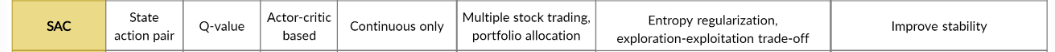

In [52]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_sac = agent.get_model("sac")
trained_sac = agent.train_model(model=model_sac, tb_log_name="sac", total_timesteps=10000 )

Output hidden; open in https://colab.research.google.com to view.

#Save Model

In [53]:
!mkdir -p saved_model
trained_sac.save('saved_model/my_modelBIST.h5') 

In [54]:
trained_sac

#Trading Part

In [55]:
print("==============Start Trading===========")
e_trade_gym = StockTradingEnv(df=trade, turbulence_threshold=250, **env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym)


==============Start Trading===========
249
hit end!


In [56]:
df_actions

,AKBNK.IS,ARCLK.IS,BIMAS.IS,EREGL.IS,GARAN.IS,HALKB.IS,PETKM.IS,PGSUS.IS,SAHOL.IS,SASA.IS,THYAO.IS,TUPRS.IS,VAKBN.IS,VESTL.IS
date,,,,,,,,,,,,,,
2020-07-27,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-28,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-29,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-30,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-08-04,100,0,100,0,100,100,0,0,0,0,0,100,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
df_account_value

profit_list = []
ac_val = list(df_account_value["account_value"])
print(ac_val)
turn =len(ac_val)
for i in range(turn):
  
  if i != turn-1:

    diff = ac_val[i+1]  - ac_val[i]
    profit_list.append(diff)
  else:
    profit_list.append(float(0))
    
print(profit_list)


[1000000.0, 999544.1445570469, 998736.7246872901, 998432.7010324001, 994101.7715206625, 993178.9188338757, 989567.2459684849, 991265.1771731378, 991367.8537642957, 995211.5303136827, 995973.7638011456, 996560.923962164, 995691.0339221477, 998741.2166747092, 997883.1451239107, 1013135.1515889165, 1021260.1348331451, 1004869.6110705376, 1008361.0537353039, 1002623.285334158, 1008904.8218493462, 1012582.0623467923, 1009329.1095630648, 998569.3029040814, 1000206.9759082319, 998113.5683306695, 994585.2646959783, 997321.0809315683, 997526.7817012311, 992114.4918453693, 1010456.3939459801, 998471.6444458487, 1000949.314695263, 1006507.9018843176, 1005129.3373939992, 1003010.7757003309, 1000508.324393654, 1002191.8815411569, 989063.4160182478, 990371.3323683741, 989193.18261323, 995858.0523519041, 1001299.7731556417, 990789.3670606615, 989143.1911715986, 1001410.0302165987, 1000609.6653483392, 999087.2416831017, 1005740.9089309217, 1003076.3987623693, 1000107.9532314301, 1008249.5693136693, 10

In [58]:
new_df = df_account_value.copy()

new_df["diff"] = np.array(profit_list)

new_df

,date,account_value,diff
0,2020-07-27,1.000000e+06,-455.855443
1,2020-07-28,9.995441e+05,-807.419870
2,2020-07-29,9.987367e+05,-304.023655
3,2020-07-30,9.984327e+05,-4330.929512
4,2020-08-04,9.941018e+05,-922.852687
...,...,...,...
244,2021-07-14,1.123946e+06,-1076.754089
245,2021-07-16,1.122870e+06,-6366.046425
246,2021-07-19,1.116504e+06,-9457.239697
247,2021-07-26,1.107046e+06,2599.674046


In [59]:
%matplotlib inline

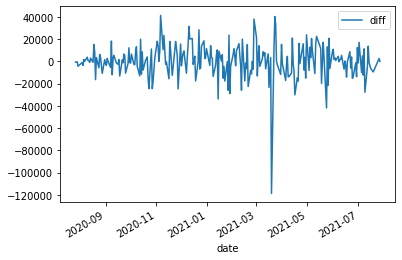

In [60]:
# hesaptaki günlük kar-zarar grafiği
new_df.plot(x='date', y='diff', kind = 'line')

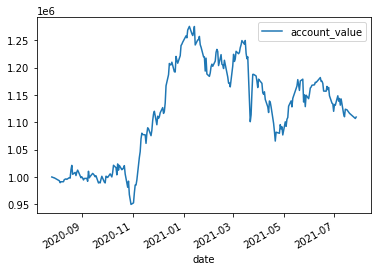

In [61]:
# total hesaptaki maliyetin değişimi
new_df.plot(x='date', y='account_value', kind = 'line')

In [62]:
df_actions

,AKBNK.IS,ARCLK.IS,BIMAS.IS,EREGL.IS,GARAN.IS,HALKB.IS,PETKM.IS,PGSUS.IS,SAHOL.IS,SASA.IS,THYAO.IS,TUPRS.IS,VAKBN.IS,VESTL.IS
date,,,,,,,,,,,,,,
2020-07-27,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-28,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-29,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-30,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-08-04,100,0,100,0,100,100,0,0,0,0,0,100,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
ticker_df = df_actions["VESTL.IS"]
ticker_df.sum()


5500

In [64]:
import os
cwd = os.getcwd()
cwd

'/content/saved_model'

In [65]:
import os
os.chdir('/content/saved_model')


with open("./" + "/df_account_value_BIST" + now + ".csv", 'a') as f1:
    df_account_value.to_csv(f1, header=False)

with open("./"+ "/df_actions_BIST" + now + ".csv", 'a') as f2:
    df_actions.to_csv(f2, header=False)




#Backtesting 

In [66]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" +"/perf_stats_all_BIST" + now + ".csv")


==============Get Backtest Results===========
Annual return          0.111038
Cumulative returns     0.109646
Annual volatility      0.207759
Sharpe ratio           0.613904
Calmar ratio           0.675218
Stability              0.395293
Max drawdown          -0.164447
Omega ratio            1.117903
Sortino ratio          0.822516
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.005659
Daily value at risk   -0.025669
dtype: float64


 #Understanding Format of Variables:

In [67]:
train

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,6.182181,6.182181,6.122160,6.165032,5.510608,13466375,AKBNK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.00000
0,14.750000,14.950000,14.500000,14.600000,11.878804,1976842,ARCLK.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.00000
0,23.525000,23.799999,23.325001,23.600000,19.072001,628882,BIMAS.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.00000
0,3.990000,4.040000,3.960000,4.040000,1.965522,6776403,EREGL.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.00000
0,7.900000,7.910000,7.740000,7.760000,6.942376,63095366,GARAN.IS,2015-07-27,0.000000,0.000000,66.666667,100.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,10.004468,10.263843,9.930361,10.123040,10.123040,29892348,SASA.IS,2020-07-24,0.633239,68.646562,138.956885,47.425085,2.90643
1281,11.750000,11.860000,11.710000,11.730000,11.730000,41921530,THYAO.IS,2020-07-24,-0.094282,49.175200,-75.939490,2.560501,2.90643
1281,87.400002,87.650002,86.949997,87.250000,87.250000,2182917,TUPRS.IS,2020-07-24,-0.166060,48.918967,-31.794696,8.924711,2.90643
1281,4.890000,4.920000,4.840000,4.880000,4.880000,39839221,VAKBN.IS,2020-07-24,-0.010792,48.479858,-67.830976,7.872245,2.90643


In [68]:
trade

,open,high,low,close,adj close,volume,tic,date,macd,rsi_30,cci_30,dx_30,turbulence
0,5.800000,5.810000,5.70,5.720000,5.578002,43319180,AKBNK.IS,2020-07-27,-0.032535,45.321645,-107.064136,3.281478,7.261721
0,22.240000,22.540001,22.10,22.160000,20.744827,10243494,ARCLK.IS,2020-07-27,1.084334,71.838800,145.124012,62.664200,7.261721
0,74.699997,75.900002,74.25,74.300003,69.351898,2675233,BIMAS.IS,2020-07-27,1.951131,65.861834,192.733720,48.082447,7.261721
0,8.410000,8.510000,8.39,8.470000,7.452500,36658368,EREGL.IS,2020-07-27,0.000343,50.769015,-40.977438,1.932329,7.261721
0,7.950000,7.960000,7.77,7.800000,7.635209,98366875,GARAN.IS,2020-07-27,-0.083367,43.797485,-114.132586,16.189562,7.261721
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,29.680000,30.299999,29.34,29.540001,29.540001,15605997,SASA.IS,2021-07-27,-0.567082,47.213518,-26.532921,13.879146,8.604229
248,12.310000,12.600000,12.24,12.550000,12.550000,90420698,THYAO.IS,2021-07-27,-0.338376,42.154444,-164.845461,45.507105,8.604229
248,91.849998,92.500000,91.00,92.349998,92.349998,2781736,TUPRS.IS,2021-07-27,-1.613261,42.913015,-125.319653,47.509144,8.604229
248,3.430000,3.440000,3.39,3.420000,3.420000,30871452,VAKBN.IS,2021-07-27,-0.036190,42.210935,-143.798826,35.035782,8.604229


In [69]:
e_train_gym

In [70]:
agent

In [71]:
model_sac

In [72]:
trained_sac

In [73]:
e_trade_gym

In [74]:
df_account_value

,date,account_value
0,2020-07-27,1.000000e+06
1,2020-07-28,9.995441e+05
2,2020-07-29,9.987367e+05
3,2020-07-30,9.984327e+05
4,2020-08-04,9.941018e+05
...,...,...
244,2021-07-14,1.123946e+06
245,2021-07-16,1.122870e+06
246,2021-07-19,1.116504e+06
247,2021-07-26,1.107046e+06


In [75]:
df_actions

,AKBNK.IS,ARCLK.IS,BIMAS.IS,EREGL.IS,GARAN.IS,HALKB.IS,PETKM.IS,PGSUS.IS,SAHOL.IS,SASA.IS,THYAO.IS,TUPRS.IS,VAKBN.IS,VESTL.IS
date,,,,,,,,,,,,,,
2020-07-27,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-28,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-29,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-07-30,100,0,100,0,100,100,0,0,0,0,0,100,0,100
2020-08-04,100,0,100,0,100,100,0,0,0,0,0,100,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0
